In [1]:
import graph_tool.all as gt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import sparse
from scipy.stats import pearsonr, ttest_ind

import networkx as nx

from utils.utils import *

In [3]:
def compute_integration(mat, rec_types="real-exponential"):
    ### Convert mat to graph_tool
    g = gt.Graph(sparse.lil_matrix(mat))

    ### Infer SBM
    state = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=True, recs=[g.ep.weight], rec_types=[rec_types]) )
    
    # Extract results
    b = gt.contiguous_map(state.get_blocks())
    state = state.copy(b=b)
    e = state.get_matrix()
    B = state.get_nonempty_B()

    ### Compute average block strength
    block_matrix = state.get_matrix()
    block_strength_matrix = np.zeros(block_matrix.shape)

    # Loop over all edges, summing weights based on block membership
    for e in g.edges():
        source_block = b[e.source()]
        target_block = b[e.target()]
        block_strength_matrix[source_block, target_block] += g.ep["weight"][e]

    ### Compute mixing parameter matrix mu
    mu_i = np.zeros(B)
    
    for i in range(B):
        s_ii = block_strength_matrix[i, i]  # intra-block strength for block i
        s_tot = np.sum([block_strength_matrix[i, j] for j in range(B)])
        s_out = s_tot - s_ii

        mu_i[i] = s_out / s_tot

    '''
    mu_matrix = np.zeros((B, B))
    for i in range(B):
        s_ii = block_strength_matrix[i, i]  # intra-block strength for block i
        for j in range(B):
            s_ij = block_strength_matrix[i, j]  # strength between block i and block j
            if s_ii + s_ij > 0:  # Avoid division by zero
                mu_matrix[i, j] = s_ij / (s_ij + s_ii)
            else:
                mu_matrix[i, j] = 0  # Set to 0 if there are no edges

    ### Compute average mixing
    mu_avg = mu_matrix[np.triu_indices(B,1)].mean()
    '''
    
    ### Compute average mixing
    mu_avg = mu_i.mean()

    ### Compute modularity
    G = nx.from_numpy_array(mat)
    mod = nx.community.modularity(G, [np.where(np.array(b)==c)[0] for c in np.unique(b)], weight='weight', resolution=1)
    
    print('Entropy:', state.entropy(), '- Avg. mixing:', mu_avg, '- Modularity:', mod)

    ### Return average mixing
    return mu_avg, state.entropy()

In [4]:
parc = 200
ses = 1

control = data_loader(which='control', ses=ses, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=ses, parc=parc, include_subctx=False, thr='mask')

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########


In [117]:
dls = []         # description length history
bs = []          # partitions

def collect_partitions(s):
        global bs, dls
        bs.append(s.get_state().a.copy())
        dls.append(s.entropy())

def get_consensus_clustering(mat, iter_tot = 100, iter_skip = 10):
    ### Convert mat to graph_tool
    g = gt.Graph(sparse.lil_matrix(mat), directed=False)

    ### Infer SBM
    state = gt.minimize_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=["real-exponential"]) )  # Initialize the Markov
                                                                              # chain from the "ground
                                                                              # state"
    print('Initial entropy:', state.entropy())

    # Clear array
    dls.clear()         # description length history
    bs.clear()          # partitions

    # Now we collect 2000 partitions; but the larger this is, the
    # more accurate will be the calculation
    print('Run MCMC...')
    gt.mcmc_equilibrate(state, force_niter=iter_tot, mcmc_args=dict(niter=iter_skip),
                        callback=collect_partitions)
    print('Final entropy:', state.entropy())
    
    # Infer partition modes
    pmode = gt.ModeClusterState(bs)
    #if pmode>1:
    #    print('WARNING: found more than one mode...')
    print('Total number of modes:', len(pmode.get_modes()))

    # Get consensus
    best_SBM = np.array( pmode.get_modes()[0].get_max(g) )

    # Clear array
    dls.clear()         # description length history
    bs.clear()          # partitions
    
    return best_SBM, state

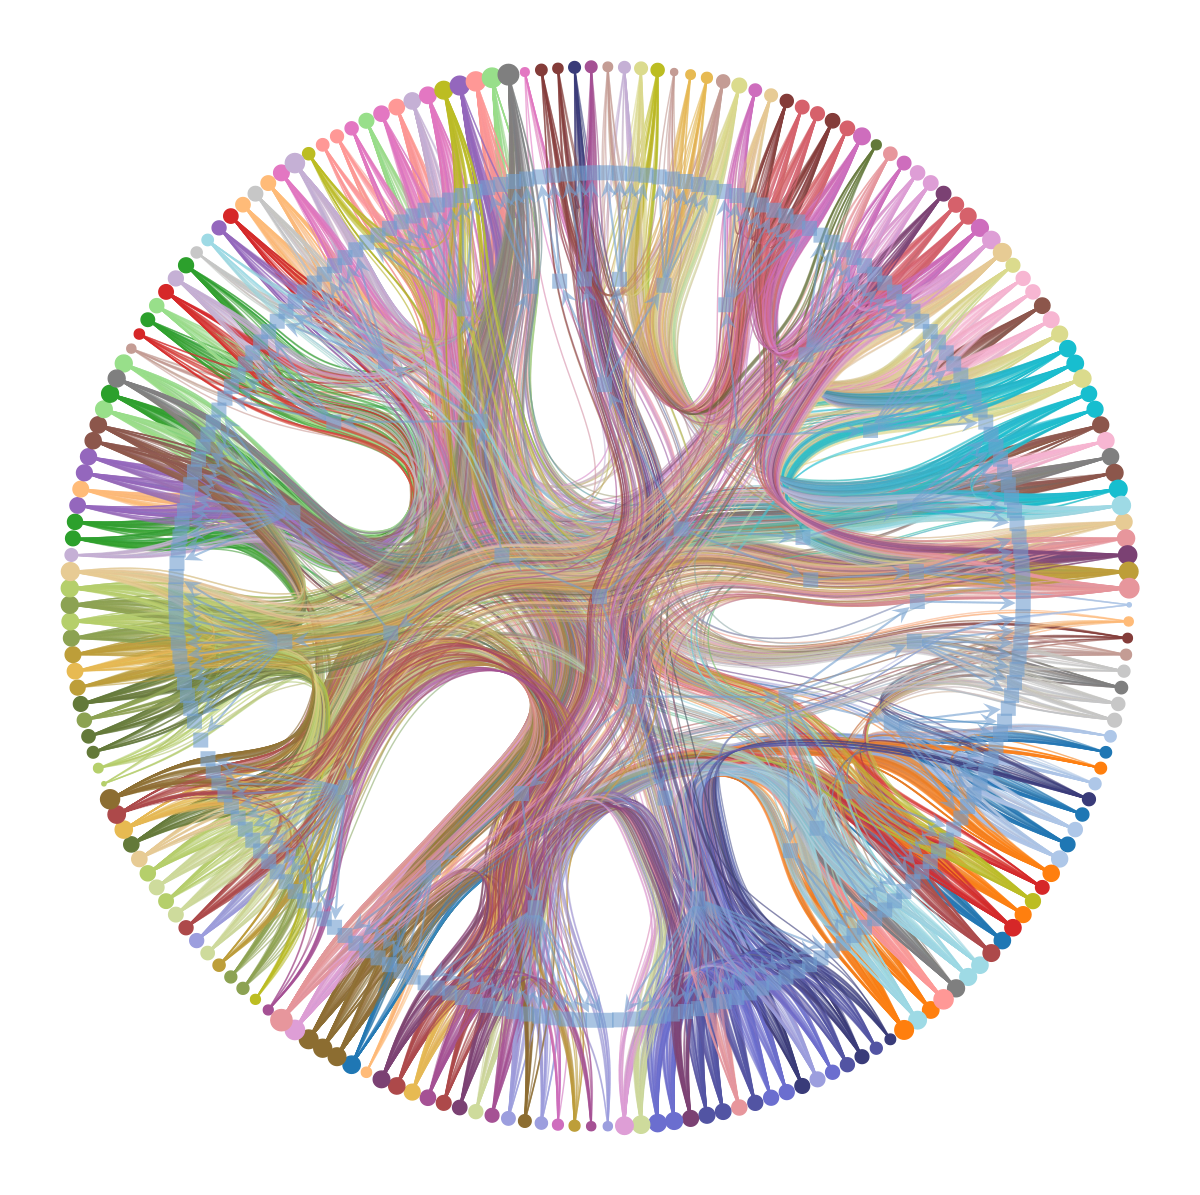

In [235]:
#g = gt.collection.data["celegansneural"]
g = gt.Graph(sparse.lil_matrix(mat), directed=False)

state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=["real-exponential"]))
#state = gt.minimize_blockmodel_dl(g)

pos, t, tpos = state.draw()

In [236]:
state.print_summary()

l: 0, N: 200, B: 199
l: 1, N: 199, B: 25
l: 2, N: 25, B: 9
l: 3, N: 9, B: 3
l: 4, N: 3, B: 1
l: 5, N: 1, B: 1


In [237]:
levels = state.get_levels()
ss = np.max([idx_s for idx_s, s in enumerate(levels) if s.get_N() > 1]) +2

res = np.zeros((ss,parc)).astype(int)

for node in range(parc):
    r = node
    for idx_s, s in enumerate(levels):
        r = s.get_blocks()[r]
        res[idx_s, node] = r

        if s.get_N() == 1 : break

In [249]:
G = nx.from_numpy_array(mat)
communities = nx.community.greedy_modularity_communities(G, weight='weight')
print( nx.community.modularity(G, communities) )

for s in range(ss):
    print(f'Level {s}:')
    print( np.unique(res[s]).size, np.unique(res[s], return_counts=True)[1] )
    print(res[s][:parc//2])
    print(res[s][parc//2:])

    print( nx.community.modularity(G, [np.where(res[s]==tmp)[0] for tmp in np.unique(res[s])]) )

0.6289504057683717
Level 0:
199 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[  1   2   3   4   5   6   7 169   9  10  11  12  13  14 160  16  17  18
  57  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  15  58  60 134  61  62  63  64  19  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83 154  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 192 120 134 122 123 124 125 126 127 128 129 130 131 132 133  84 135 136
 137 138 1

In [188]:
G = nx.from_numpy_array(mat)

best_SBM = gt.contiguous_map(state.get_blocks())

communities = nx.community.greedy_modularity_communities(G, weight='weight')

print( nx.community.modularity(G, communities), nx.community.modularity(G, [np.where(list(best_SBM)==tmp)[0] for tmp in np.unique(best_SBM)]) )

0.6289504057683717 0.375701420225719


In [ ]:
if True:
    ### Convert mat to graph_tool
    g = gt.Graph(sparse.lil_matrix(mat), directed=False)

    ### Infer SBM
    state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=["real-exponential"]) )  # Initialize the Markov
                                                                              # chain from the "ground
                                                                              # state"
    print('Initial entropy:', state.entropy())

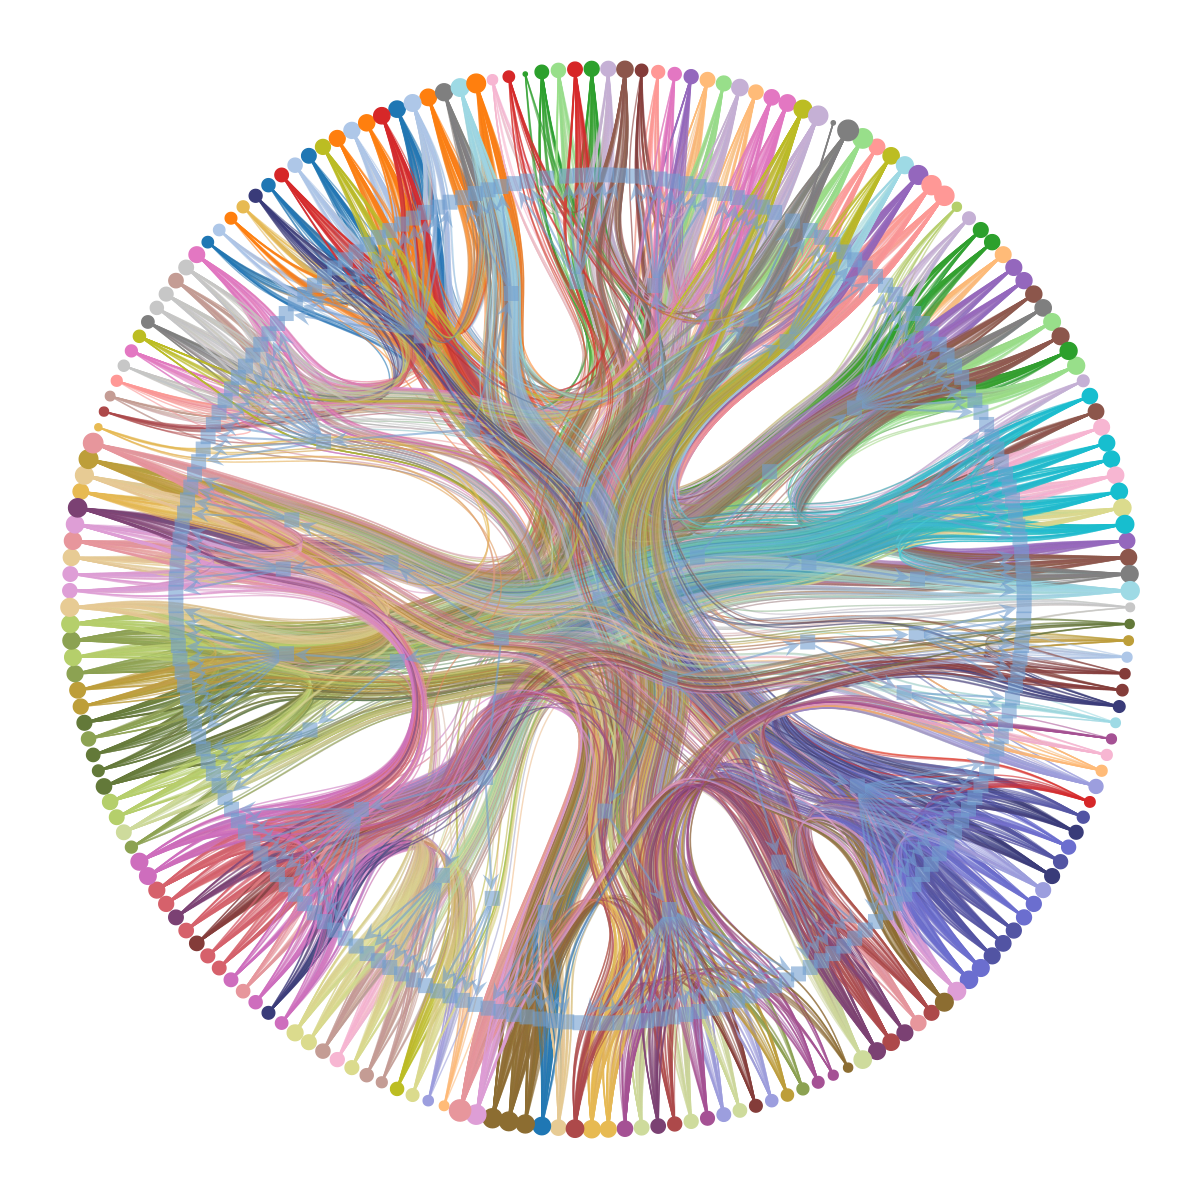

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6ed04fb620, at 0x7f6e9d373a70>,
 <GraphView object, directed, with 437 vertices and 436 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f6e9c0efb00, at 0x7f6e9a59d9a0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f6e9c0efb00, at 0x7f6e9a59e5d0>, False), at 0x7f6e9c0efb00>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6e9c0efb00, at 0x7f6e9a59ef90>)

In [127]:
state.draw()

In [146]:
block_hierarchy

[<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f6ed04fb620, at 0x7f6e9b21ec00>,
 PropertyArray([ 82, 107, 107, 107, 107, 107, 158, 107, 107, 107,  60, 107,
                107,  60, 107, 183, 186, 116,  85, 168,  85,  85,  85, 149,
                149, 186,  85, 149,  85,  79, 149, 107, 102, 107, 149, 186,
                 76,  67,  67,  67,  67,  85,   9,  85, 186, 149, 186, 116,
                 51,  85,  85,  51,   9, 149,  85,  11,  11,  11,  76,  76,
                 76, 116, 116, 186,  76, 149,  11, 168,  51,  51,  85,  60,
                 79,   9,  76,  76,  76, 158,  76,  76, 107,  76, 116, 183,
                 67, 183,  11,  51,  11,  11,  51,  51,  51,  51,  51,   9,
                 60,  67, 168,  79, 107, 158, 102, 102,  83, 102, 102, 102,
                102, 102, 102, 102, 102, 102, 102, 102,  61,  61, 168, 183,
                114, 158, 114, 114,  23, 114, 114,  23,  61, 114,  23, 114,
                 23, 114,  85, 143,  61,  23,  61,  61, 102,  61

In [144]:
r = levels[0].get_blocks()[1]    # group membership of node 46 in level 0
print(r)
r = levels[1].get_blocks()[r]     # group membership of node 46 in level 1
print(r)
r = levels[2].get_blocks()[r]     # group membership of node 46 in level 2
print(r)
r = levels[3].get_blocks()[r]     # group membership of node 46 in level 2
print(r)
r = levels[4].get_blocks()[r]     # group membership of node 46 in level 2
print(r)

2
107
6
8
0


In [123]:
state.print_summary()

l: 0, N: 200, B: 198
l: 1, N: 198, B: 24
l: 2, N: 24, B: 10
l: 3, N: 10, B: 4
l: 4, N: 4, B: 1
l: 5, N: 1, B: 1


In [124]:
levels = state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 200 blocks (198 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 200 vertices and 3480 edges, 1 internal edge property, at 0x7f6ed04fb620>, at 0x7f6e9d372360>
<BlockState object with 198 blocks (24 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 200 vertices and 3478 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f6e99c93590>, at 0x7f6e9aed89b0>
<BlockState object with 29 blocks (10 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 198 vertices and 196 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f6e99c91b50>, at 0x7f6e99c923f0>
<BlockState object with 10 blocks (4 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 29 vertices and 50 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f6e9a547140>, at 0x7f6e99c92b10>
<BlockState object with 4 blocks (1 nonempty), with 1 edge cov

In [179]:
mat = control.load_matrix(1)
mat = mat / mat.max()

#mat = np.log(mat)
#mat[np.isinf(mat)] = 0
#mat = mat / mat.max()

G = nx.from_numpy_array(mat)

best_SBM, best_state = get_consensus_clustering(mat)

communities = nx.community.greedy_modularity_communities(G, weight='weight')

print( nx.community.modularity(G, communities), nx.community.modularity(G, [np.where(best_SBM==tmp)[0] for tmp in np.unique(best_SBM)]) )

- Loading sub-041
Initial entropy: -2964.685748705066
Run MCMC...
Final entropy: -3040.0280996373144
Total number of modes: 1
0.6289504057683717 0.4080957205370822


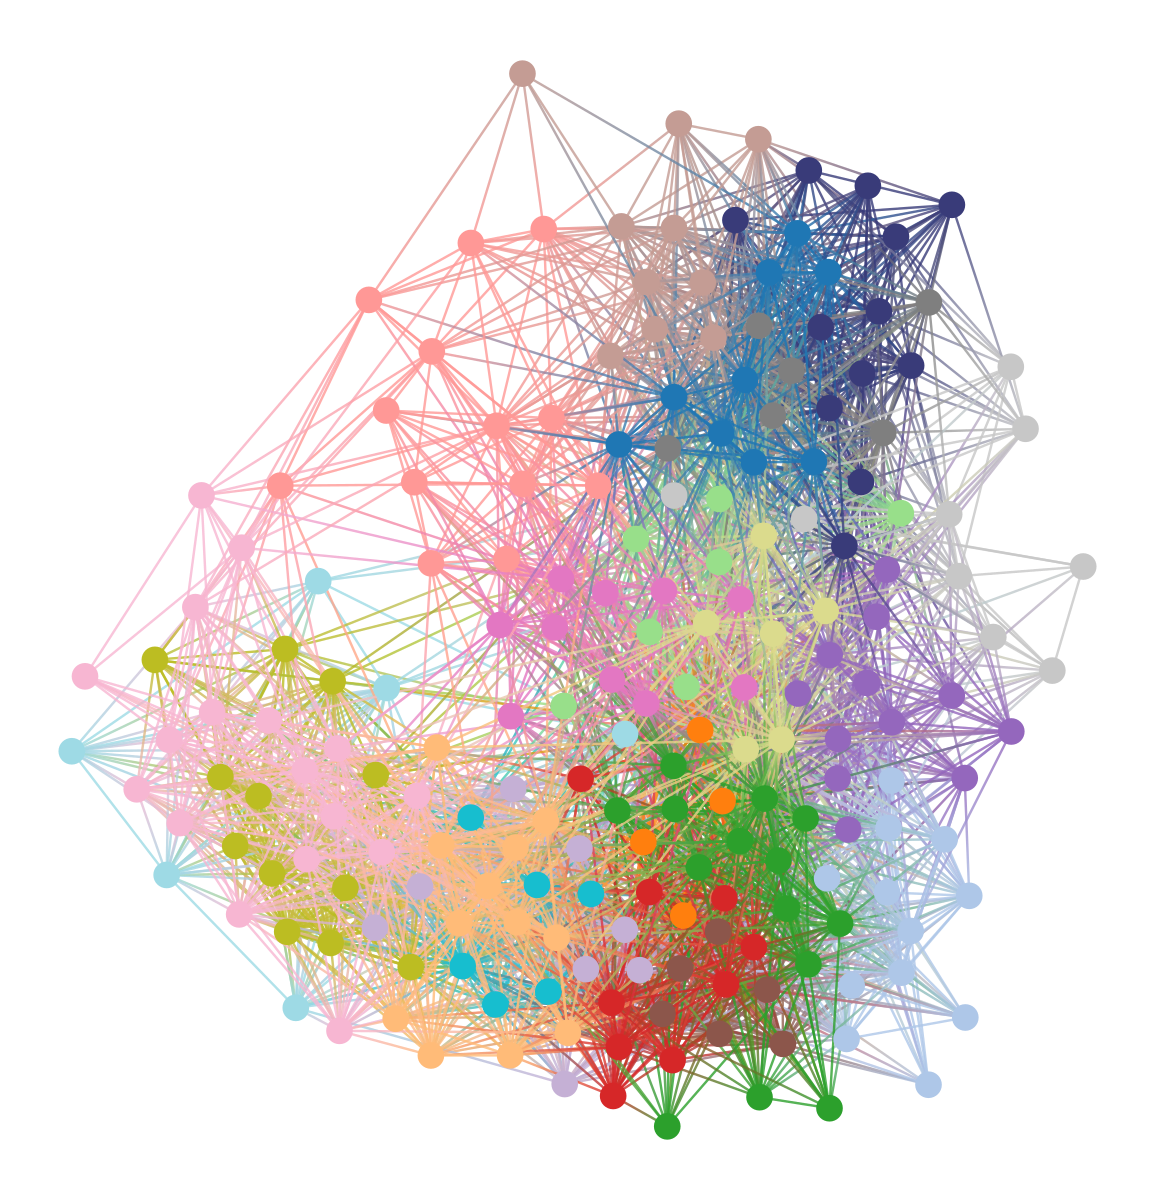

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6e9c323fe0, at 0x7f6e9a22cd70>

In [119]:
best_state.draw()

In [120]:
[np.where(best_SBM==tmp)[0] for tmp in np.unique(best_SBM)], len(np.unique(best_SBM))

([array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 30, 32, 79]),
  array([ 9, 12, 13, 95, 99]),
  array([14, 15, 31, 35, 43, 58, 59, 60, 61, 63, 73, 74, 75, 76, 77, 78, 80,
         81]),
  array([16, 18, 22, 23, 24, 26, 29, 33, 34, 44, 45, 62]),
  array([42, 46, 48, 49, 68, 69, 86, 92]),
  array([17, 19, 20, 21, 25, 27, 40, 41, 53, 72]),
  array([36, 37, 38, 70, 96, 97, 98]),
  array([47, 54, 64, 82, 84]),
  array([50, 51, 89, 90, 91, 93, 94]),
  array([55, 65, 66, 67, 83, 85, 87, 88]),
  array([100, 135, 147, 151, 161, 162, 184, 185, 186, 187, 188]),
  array([101, 102, 103, 104, 105, 107, 108, 110, 111, 163]),
  array([106, 109, 112, 113, 114, 134, 176, 197]),
  array([115, 116, 140, 148, 152, 164, 165, 166, 167, 181, 182, 183]),
  array([117, 118, 120, 123, 126, 127, 129, 131, 133, 136, 137, 138, 143,
         149, 156]),
  array([119, 121, 122, 124, 125, 128, 130, 132, 144, 145, 150, 157]),
  array([139, 141, 142, 177, 198, 199]),
  array([146, 154, 155, 172, 175, 178, 179, 180, 

In [87]:
[np.array(list(tmp)) for tmp in communities], len(communities)

([array([129, 136, 137, 138, 140, 144, 145, 146, 149, 150, 153, 154, 158,
         159, 160, 165, 168, 169, 170, 171, 172, 173, 174, 175, 179, 180,
         189, 190, 191, 192, 193, 194, 195, 196, 117, 118, 119, 120, 121,
         123, 124, 126, 127]),
  array([134, 135, 139, 141, 147, 148, 151, 152, 161, 162, 163, 164, 166,
         167, 176, 181, 182, 183, 184, 185, 186, 187, 188, 197, 100, 101,
         102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
         115, 116]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 30,
         31, 32, 36, 43, 56, 57, 58, 59, 60, 61, 63, 70, 73, 74, 75, 76, 77,
         78, 79, 80, 81, 95, 99]),
  array([71, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 96, 33,
         34, 35, 97, 37, 38, 39, 40, 41, 98, 44, 45, 52, 53, 62]),
  array([64, 65, 66, 67, 68, 69, 72, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
         92, 93, 94, 42, 46, 47, 48, 49, 50, 51, 54, 55]),
  array([128, 130, 131, 132, 133, 1

In [14]:
mat = stroke.load_matrix(1)
mat = mat / mat.max()

#mat = np.log(mat)
#mat[np.isinf(mat)] = 0
#mat = mat / mat.max()

G = nx.from_numpy_array(mat)

best_SBM = get_consensus_clustering(mat)

communities = nx.community.greedy_modularity_communities(G, weight='weight')
print( nx.community.modularity(G, communities), nx.community.modularity(G, [np.where(best_SBM==tmp)[0] for tmp in np.unique(best_SBM)]) )

- Loading sub-201
Initial entropy: -5764.577390082186
Run MCMC...
Final entropy: -5857.654452580642
Total number of modes: 1
0.6265521780006181 0.4252346426525773


In [ ]:
len(communities), np.unique(best_SBM).size

In [20]:
mod_control, mod_stroke = [], []

for mat in control:
    if mat is None:
        continue

    mat = mat / mat.max()
        
    best_SBM = get_consensus_clustering(mat)
    mod = nx.community.modularity(nx.from_numpy_array(mat), [np.where(best_SBM==tmp)[0] for tmp in np.unique(best_SBM)])
    
    mod_control.append(mod)

for mat in stroke:
    if mat is None:
        continue

    mat = mat / mat.max()
        
    best_SBM = get_consensus_clustering(mat)
    mod = nx.community.modularity(nx.from_numpy_array(mat), [np.where(best_SBM==tmp)[0] for tmp in np.unique(best_SBM)])
    
    mod_stroke.append(mod)

- Loading sub-040
Initial entropy: -5046.245878375428
Run MCMC...
Final entropy: -5199.420087226486
Total number of modes: 1
- Loading sub-041
Initial entropy: -6584.698986150876
Run MCMC...
Final entropy: -6701.53862663923
Total number of modes: 1
- Loading sub-042
Initial entropy: -8551.42467026663
Run MCMC...
Final entropy: -8731.999674613191
Total number of modes: 1
- Loading sub-043
Initial entropy: -7801.208799268898
Run MCMC...
Final entropy: -8017.420750268511
Total number of modes: 1
- Loading sub-044
Initial entropy: -6602.417908924623
Run MCMC...
Final entropy: -6764.986317097586
Total number of modes: 1
- Loading sub-045
Initial entropy: -6163.678506988549
Run MCMC...
Final entropy: -6467.751551563644
Total number of modes: 1
- Loading sub-046
Initial entropy: -4111.939530272037
Run MCMC...
Final entropy: -4230.5001853333215
Total number of modes: 1
- Loading sub-047
Initial entropy: -4877.327181052143
Run MCMC...
Final entropy: -5071.884941304321
Total number of modes: 1
-

In [21]:
int_control = mod_control.copy()

In [23]:
int_stroke = mod_stroke.copy()

In [24]:
mod_control, mod_stroke = [], []

for mat in control:
    if mat is None:
        continue
    G = nx.from_numpy_array(mat / mat.max())
    communities = nx.community.greedy_modularity_communities(G, weight='weight', resolution=1, cutoff=1, best_n=None)
    mod = nx.community.modularity(G, communities, weight='weight', resolution=1)
    mod_control.append(mod)

for mat in stroke:
    if mat is None:
        continue
    G = nx.from_numpy_array(mat / mat.max())
    communities = nx.community.greedy_modularity_communities(G, weight='weight', resolution=1, cutoff=1, best_n=None)
    mod = nx.community.modularity(G, communities, weight='weight', resolution=1)
    mod_stroke.append(mod)

- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
- Loading sub-200
- Loading sub-201
- Loading sub-202
- Loading sub-203
- Loading sub-204
- Loading sub-205
- Loading sub-206
- Loading sub-208
- Loading sub-209
- Loading sub-210
- Loading sub-213
- Loading sub-216
- Loading sub-219
- Loading sub-222
- Loading sub-224
- Loading sub-226
- Loading sub-227
- Loading sub-232
- Loading sub-233
- Loading sub-234
- Loading sub-235
- Loading sub-238
- Loading sub-239
- Loading sub-240
- Loading sub-243
- Loading sub-245
- Loading 

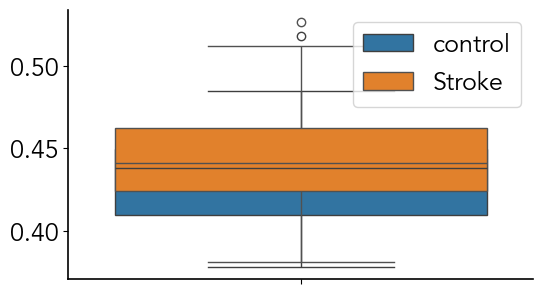

In [252]:
sns.boxplot(int_control, label='control')
sns.boxplot(int_stroke, label='Stroke')
plt.legend()
plt.show()

In [260]:
for i, tmp in enumerate(int_control):
    np.save(f'results/modularity_sbm/mod_sbm_{control.names[i]}_parc_{parc}', tmp)

for i, tmp in enumerate(int_stroke):
    np.save(f'results/modularity_sbm/mod_sbm_{stroke.names[i]}_parc_{parc}', tmp)

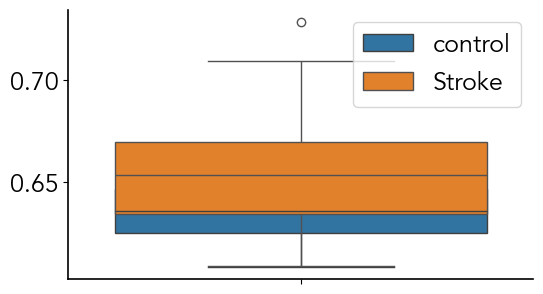

In [253]:
sns.boxplot(mod_control, label='control')
sns.boxplot(mod_stroke, label='Stroke')
plt.legend()
plt.show()

In [27]:
pearsonr(mod_control, int_control), pearsonr(mod_stroke, int_stroke)

(PearsonRResult(statistic=0.46944254573178135, pvalue=0.010193496283912052),
 PearsonRResult(statistic=0.42008729799687616, pvalue=0.002387783768716532))

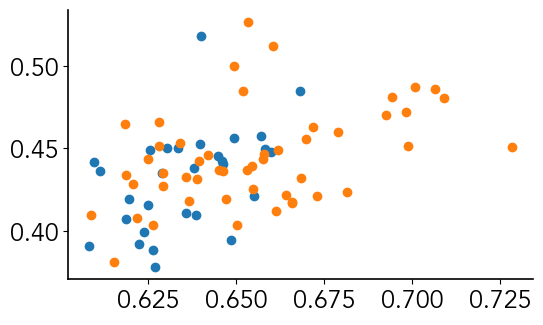

In [29]:
plt.plot(np.array(mod_control), int_control, 'o')
plt.plot(np.array(mod_stroke), int_stroke, 'o')

plt.show()

In [31]:
def load_result(which, var_name, thr, include_subctx, only_matched=False):
    folder = 'results/'+which+'/'
    
    # Init empty list
    ress = []
        
    for tmp_dict in dict_all:
        for parc in tmp_dict['parcs']:
            for sess in tmp_dict['sessions']:
                # Load names
                data = data_loader(which=tmp_dict['name'], ses=sess, parc=parc, thr=thr, include_subctx=include_subctx)
                
                # Load results
                for (tmp_full_name, tmp_name) in zip(data.full_names, data.names):
                    try:
                        tmp_res = np.loadtxt(folder+tmp_full_name)
                        ress.append([tmp_dict['name'], sess, parc, tmp_name, tmp_res.mean(), tmp_res])
                    except:
                        continue
                        
    # Create pandas dataset
    return pd.DataFrame(ress, columns=['name', 'session', 'parc', 'sub', var_name+'_avg', var_name+'_all'])

In [32]:
which = 'dimensionality'

ress = load_result(which, var_name='dim', thr=None, include_subctx=False)

######## control - ses 01 - parc 100 - total 29 - thr None - subctx False ########
######## control - ses 02 - parc 100 - total 22 - thr None - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr None - subctx False ########
######## control - ses 02 - parc 200 - total 22 - thr None - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr None - subctx False ########
######## control - ses 02 - parc 500 - total 22 - thr None - subctx False ########
######## control - ses 01 - parc 1000 - total 29 - thr None - subctx False ########
######## control - ses 02 - parc 1000 - total 22 - thr None - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr None - subctx False ########
######## stroke - ses 02 - parc 100 - total 32 - thr None - subctx False ########
######## stroke - ses 03 - parc 100 - total 24 - thr None - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr None - subctx False ########
######

In [33]:
ress = ress[ress['parc']==parc]
ress = ress[ress['session']==1]

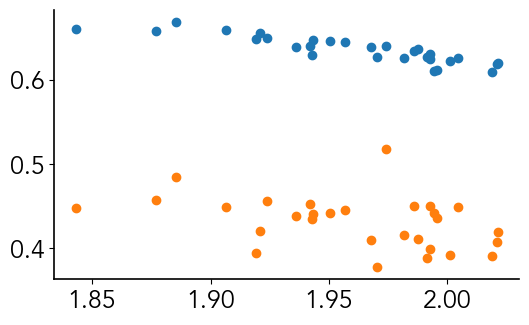

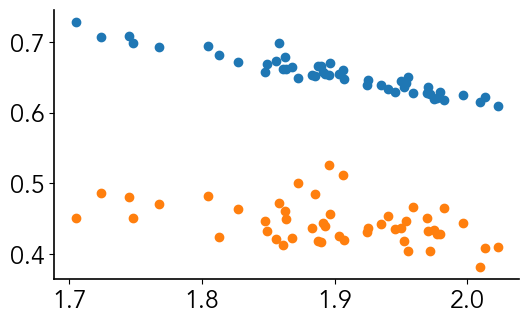

In [34]:
which = 'control'

plt.plot(ress[ress['name'] == which]['dim_avg'].values, np.array(mod_control), 'o')
plt.plot(ress[ress['name'] == which]['dim_avg'].values, np.array(int_control), 'o')
plt.show()

which = 'stroke'

plt.plot(ress[ress['name'] == which]['dim_avg'].values, np.array(mod_stroke), 'o')
plt.plot(ress[ress['name'] == which]['dim_avg'].values, np.array(int_stroke), 'o')
plt.show()

In [36]:
pearsonr(ress[ress['name'] == 'control']['dim_avg'].values, np.array(mod_control)), pearsonr(ress[ress['name'] == 'control']['dim_avg'].values, int_control)

(PearsonRResult(statistic=-0.889260451532389, pvalue=1.1411794249776753e-10),
 PearsonRResult(statistic=-0.3969723824713614, pvalue=0.03298834779097693))

In [37]:
np.where( ~np.isnan(ress[ress['name'] == 'stroke']['dim_avg'].values) )[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [38]:
good_idx = np.where( ~np.isnan(ress[ress['name'] == 'stroke']['dim_avg'].values) )[0]

pearsonr(ress[ress['name'] == 'stroke']['dim_avg'].values[good_idx], (1-np.array(mod_stroke))[good_idx]), pearsonr(ress[ress['name'] == 'stroke']['dim_avg'].values[good_idx], np.array(int_stroke)[good_idx])

(PearsonRResult(statistic=0.953550381692627, pvalue=3.906756211418446e-26),
 PearsonRResult(statistic=-0.42203378379159956, pvalue=0.0025238995663481012))

In [ ]:
mat_log = np.log10(mat)
mat_log[np.isinf(mat_log)] = 0

In [ ]:
mat_log

In [ ]:
plt.hist(mat.flatten(), bins=np.logspace(np.log10(mat[mat>0].min()),np.log10(mat.max()), 50))
plt.xscale('log')
plt.show()

In [ ]:
g = gt.collection.data["football"]
print(g)

In [ ]:
state = gt.minimize_blockmodel_dl(g) #state_args=dict(recs=[g.ep.weight], rec_types=["discrete-binomial"]

In [ ]:
b = state.get_blocks()

In [22]:
b

<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f01fcf25a90, at 0x7f01fcf4b770>

In [ ]:
# let us obtain a contiguous range first, which will facilitate
# visualization

b = gt.contiguous_map(state.get_blocks())
state = state.copy(b=b)

e = state.get_matrix()

B = state.get_nonempty_B()
plt.matshow(e.todense()[:B, :B])

In [ ]:
bg = state.get_bg()
ers = state.mrs    # edge counts
nr = state.wr      # node counts

In [ ]:
g = gt.Graph(sparse.lil_matrix(mat))

In [ ]:
mat.astype(bool).astype(int)

In [ ]:
g = gt.Graph(sparse.lil_matrix(mat))
state = gt.minimize_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=["real-normal"]) )
print('Entropy:', state.entropy())

# let us obtain a contiguous range first, which will facilitate
# visualization

b = gt.contiguous_map(state.get_blocks())
state = state.copy(b=b)

e = state.get_matrix()

B = state.get_nonempty_B()
plt.matshow(e.todense()[:B, :B])
plt.show()

In [ ]:
g = gt.Graph(sparse.lil_matrix(mat))
state = gt.minimize_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=["real-exponential"]) )
print('Entropy:', state.entropy())

# let us obtain a contiguous range first, which will facilitate
# visualization

b = gt.contiguous_map(state.get_blocks())
state = state.copy(b=b)

e = state.get_matrix()

B = state.get_nonempty_B()
plt.matshow(e.todense()[:B, :B])
plt.show()

In [ ]:
block_matrix = state.get_matrix()

# Now, instead of just the number of edges, compute block strengths using edge weights
block_strength_matrix = np.zeros(block_matrix.shape)

# Loop over all edges, summing weights based on block membership
for e in g.edges():
    source_block = b[e.source()]
    target_block = b[e.target()]
    block_strength_matrix[source_block, target_block] += g.ep["weight"][e]

# Now, block_strength_matrix contains the sum of edge weights (strengths) between each block pair
plt.matshow(block_strength_matrix)
plt.colorbar()
plt.show()

In [ ]:
# Initialize the mixing parameter matrix mu
mu_matrix = np.zeros((B, B))

for i in range(B):
    s_ii = block_strength_matrix[i, i]  # intra-block strength for block i
    for j in range(B):
        s_ij = block_strength_matrix[i, j]  # strength between block i and block j
        if s_ii + s_ij > 0:  # Avoid division by zero
            mu_matrix[i, j] = s_ij / (s_ij + s_ii)
        else:
            mu_matrix[i, j] = 0  # Set to 0 if there are no edges

In [ ]:
plt.matshow(mu_matrix)
plt.show()

In [ ]:
mu_matrix[np.triu_indices(B,1)].mean()

In [ ]:
np.diag(mu_matrix)